In [1]:
import warnings
warnings.filterwarnings('ignore')

In [359]:
from astropy.io import fits
import numpy as np
from pyrafspec.fitslist import *
import matplotlib.pyplot as plt
from pyrafspec.splicing_spectrum import *
import os
from astropy.time import Time
from PyAstronomy import pyasl
from astropy import coordinates as coord
from pyrafspec.spec_tools import rvcorr_spec
import joblib
import collections
plt.style.use('lijiaostyle')

In [390]:
splicingorderdict = {}

In [394]:
#filename = '/home/lcq/media/backup/240cm/yf01_reduced/20210105/raw/ljg2m401-yf01-20210105-0049-x00_1ds.fits'
filename = '/home/lcq/media/backup/240cm/yf01_reduced/20210104/raw/ljg2m401-yf01-20210104-0180-e00_1ds.fits'

In [395]:
hdu = fits.open(filename)
data = hdu[0].data
header = hdu[0].header
hdu.close()
print(f'data.shape = {data.shape}')

data.shape = (6, 3150)


In [397]:
splicingorderdict

{'ljg2m401-yf01-20210105-0049-x00_1ds.fits': [12, 11, 10, 9, 8],
 'ljg2m401-yf01-20210104-0180-e00_1ds.fits': [12, 11, 10, 9, 8]}

spec.orders = [12, 11, 10, 9, 8, 7]


(0.0, 2000.0)

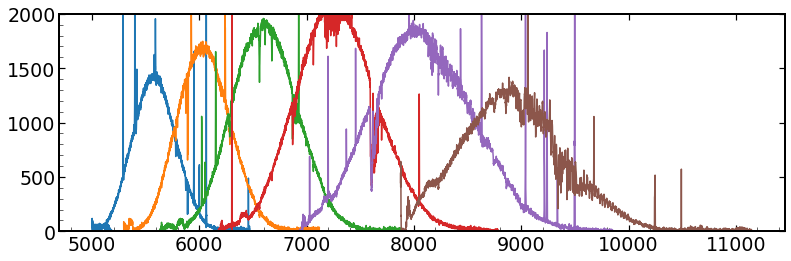

In [398]:
spec = load_multispec(filename)
print(f'spec.orders = {spec.orders}')
splicingorderdict[os.path.basename(filename)] = [12, 11, 10, 9, 8]

fig, ax = plt.subplots(1,1, figsize=(13,4))
for _order in  [12, 11, 10, 9, 8, 7]:
    plt.plot(spec[_order].wv,  spec[_order].flux)
plt.ylim(0,2000)

# splicing spectrum

In [399]:
orders

[12, 11, 10, 9, 8]

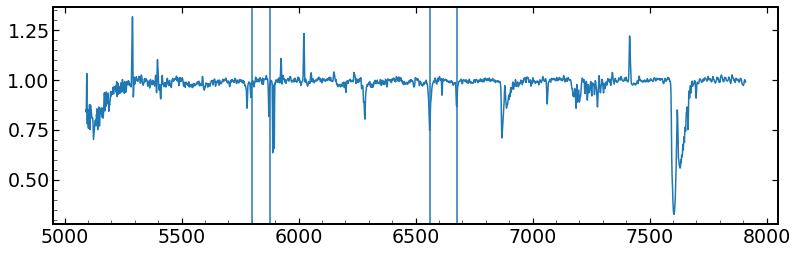

In [400]:
orders = splicingorderdict[os.path.basename(filename)]
logwave, flux, fluxerr = splicing_irafspectrum(filename, R=1500, N=3, lam_start=5000, lam_end=8000, pix=[590, 2200], funcnorm= None, orders=orders, sigma =3, itera=2,\
                       percentile_up=99.9, percentile_low=0.0,window_length=9, \
                       polyorder=2, show=False)

#---------------------------------------------------
fig, ax = plt.subplots(1,1, figsize=[13,4])
plt.plot(10**logwave, flux)
#plt.xlim(6100, 6800)
plt.axvline(x=6563)
plt.axvline(x=6678)
plt.axvline(x=5876)
plt.axvline(x=5800)
#-----------------------------------------------------

#-----------------------write log10wave and flux into a fits-----------------------
fout = os.path.join(os.path.dirname(filename), os.path.basename(filename)[:-5] +'_splicing.fits')
pyrafspc1d2fits(filename, logwave, flux, fluxerr, dire=None, fout=fout)

(6500.0, 6700.0)

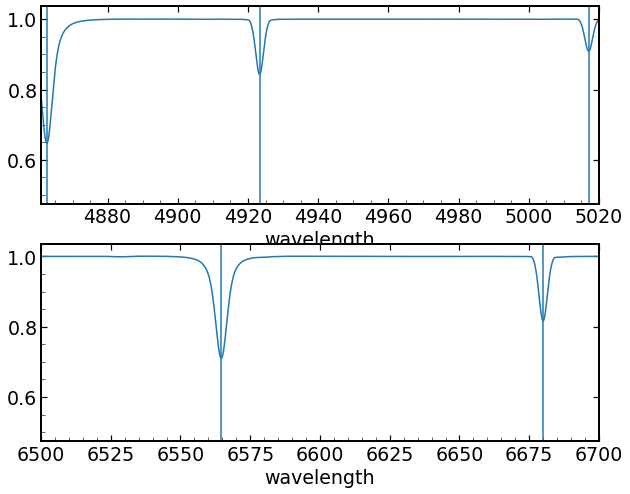

In [401]:
#rvm = joblib.load('/media/share/lijiao/TLUSTY_grid/tlusty_for_bfosc_rv_tyc3340.dump')
#from laspec.ccf import RVM
#_ind = (rvm.pmod[:,0] >= 27000) & (rvm.pmod[:,0] <= 31000)
#pmod_rv = rvm.pmod[_ind]
#wavemod_rv = rvm.wave_mod
#fluxmod_rv = rvm.flux_mod[_ind]
#rvm = RVM(pmod_rv, pyasl.airtovac2(wavemod_rv), fluxmod_rv, npix_lv=5)

### check rvm model wave is in vacuum or air
haVac = 6564.66464
haAir = 6562.85175
heIAir = 6678.151
heIVac = 6679.995
fig, axs = plt.subplots(2,1,figsize=[10,8])
plt.sca(axs[0])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=4862.6) #vacum
plt.axvline(x=4923.3)#vacuum
plt.axvline(x=5017.07)#vacuum
plt.xlabel('wavelength')
plt.xlim(4861, 5020)

plt.sca(axs[1])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=haVac)
plt.axvline(x=heIVac)
plt.xlabel('wavelength')
plt.xlim(6500, 6700)

rvm.pmod = [[3.00e+04 3.75e+00 1.00e+00 1.00e+01]]


(5200.0, 6900.0)

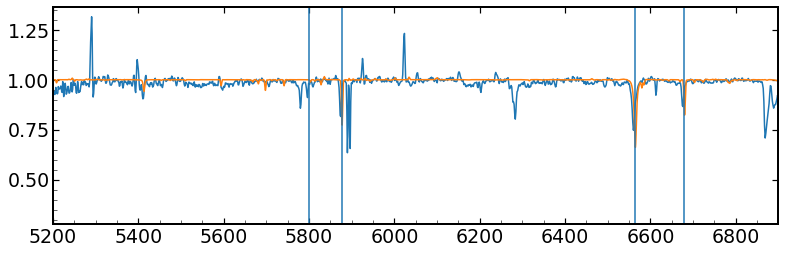

In [402]:
_ind = (rvm.pmod[:, 0] == 30000) & (rvm.pmod[:, 2] == 1) & (rvm.pmod[:, 1] == 3.75)
print(f'rvm.pmod = {rvm.pmod[_ind]}')


fig, ax = plt.subplots(1,1, figsize=[13,4])
plt.plot(10**logwave, flux)
plt.plot(rvm.wave_mod, rvm.flux_mod[_ind][0])
#plt.xlim(6100, 6800)
plt.axvline(x=6563)
plt.axvline(x=6678)
plt.axvline(x=5876)
plt.axvline(x=5800)
plt.xlim(5200, 6900)

ljg2m401-yf01-20210104-0180-e00_1ds.fits


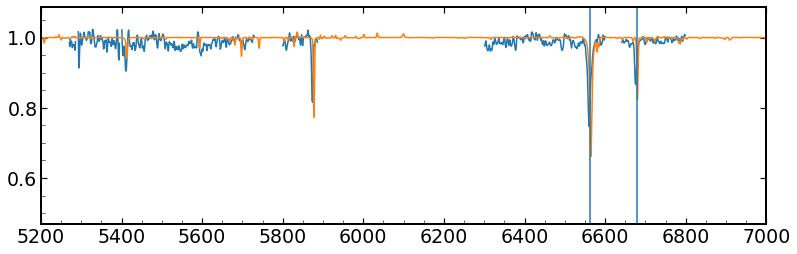

In [403]:
hdul = fits.open(fout)
wave = 10**hdul[1].data['loglambda']
_flux = hdul[1].data['flux'].copy()
hdul.close()


ind = ~( (flux > 1.05) |
    (wave < 5270) |
    ((wave >5730) & (wave<5799)) |
    ((wave >5887) & (wave < 6300))|
    ((wave > 6800) & (wave < 7000)) |
    ((wave > 6600) & (wave < 6640))|
    (wave > 7150) |
    np.isnan(flux)
   ) 
flux[~ind] = np.nan

fig, ax = plt.subplots(1,1, figsize=[13,4])
plt.plot(wave, flux)
plt.plot(rvm.wave_mod, rvm.flux_mod[_ind][0])
#plt.xlim(6100, 6800)
plt.axvline(x=6563)
plt.axvline(x=6678)
plt.xlim(5200, 7000)
print(os.path.basename(filename))

In [404]:
hdul = fits.open(fout)
wave_obs, flux_obs = wave[ind],  hdul[1].data['flux'][ind]
flux_err = np.random.normal(loc=0, scale=np.std(flux_obs), size=np.sum(ind))
rvr = rvm.measure(wave_obs, flux_obs, flux_err=flux_err, nmc=100, rv_grid=np.arange(-1000, 1000, 5),
                    )


rv = rvr['rv_opt']
err = np.sqrt(np.sum(np.diff(rvr['rv_pct'])**2)/2)
hdul[0].header['rv'] = (rv - hdul[0].header['BARYCORR'], 'barycentric radial velocity (km/s)')
hdul[0].header['rv_err'] = (err, 'radial velocity error(km/s)' )
hdul.writeto(fout, overwrite=True)
print(os.path.basename(filename))

ljg2m401-yf01-20210104-0180-e00_1ds.fits


In [405]:
per1, tc1 = (3.3900552015211796, 1821.4245165431814)
phase = np.mod((hdul[0].header['bjd'] - tc1)/per1, 1)
if phase > 0.5: phase -=1
print(f'phase = {phase}')
print(f"rv = {rv - hdul[0].header['BARYCORR']} \pm {err}")

phase = 0.275364613160491
rv = -180.35277456360873 \pm 8.486506824691938


In [406]:
TYC3340list = ['/home/lcq/media/backup/240cm/yf01_reduced/20210105/raw/ljg2m401-yf01-20210105-0049-x00_1ds_splicing.fits',
              '/home/lcq/media/backup/240cm/yf01_reduced/20210104/raw/ljg2m401-yf01-20210104-0180-e00_1ds_splicing.fits']

In [407]:
hdul[0].header['bjd']

2459219.132717261

In [408]:
for _fname in TYC3340list:
    header = fits.getheader(_fname)
    phase = np.mod((header['bjd'] - tc1)/per1, 1)
    if phase > 0.5: phase -=1
    print(header['bjd'],  phase, header['rv'])

2459219.999129371 -0.4690607551019639 -50.78196559941792
2459219.132717261 0.275364613160491 -180.3527745636087
